In [1]:
import mxnet
from mxnet import gluon
from mxnet import nd
from mxnet.gluon.model_zoo import vision
import Read_Data
import Net_Train

### 常用变量定义

In [2]:
Path_Image = '../../../Data/train_1/'
Path_Label = '../../../Data/'
File_Name = 'Train_CIFAR10.csv'
Label_Name = 'trainLabels_1.csv'
Batch_size = 64
Size = 96

### 通过GPU训练数据

In [3]:
def try_gpu():
    """If GPU is available, return mx.gpu(0); else return mx.cpu()"""
    try:
        ctx = mxnet.gpu()
        _ = nd.array([0], ctx=ctx)
    except:
        ctx = mxnet.cpu()
    return ctx
ctx = try_gpu()
#ctx = mxnet.cpu()
print(ctx)

gpu(0)


## 创建深度网络

In [4]:
from mxnet import gluon
from mxnet import init
from mxnet.gluon import nn
ConvNet = nn.Sequential()
with ConvNet.name_scope():
    ConvNet.add(
        nn.Conv2D(channels=20, kernel_size=5, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Conv2D(channels=50, kernel_size=3, activation='relu'),
        nn.MaxPool2D(pool_size=2, strides=2),
        nn.Flatten(),
        nn.Dense(128, activation="relu"),
        nn.Dense(10)
    )
ConvNet.initialize(init=init.Xavier(), ctx=ctx)

In [12]:
ResNet = vision.resnet18_v2(classes=10)
ResNet.initialize(init=init.Xavier(), ctx = ctx)
# print(AlexNet)

AlexNet = vision.alexnet(pretrained=True)
# AlexNet.initialize(init=init.Xavier(), ctx = ctx)

Fine_Tuning_AlexNet = vision.alexnet(classes=10)
Fine_Tuning_AlexNet.features = AlexNet.features
Fine_Tuning_AlexNet.classifier.initialize(init.Xavier())
print(Fine_Tuning_AlexNet)

# Fine_Tuning the param need to init in CPU then reset to CPU
Fine_Tuning_AlexNet.collect_params().reset_ctx(ctx)

loss = gluon.loss.SoftmaxCrossEntropyLoss()
Trainer = gluon.Trainer(ResNet.collect_params(), 'sgd', {'learning_rate': 1})

AlexNet(
  (features): HybridSequential(
    (0): Conv2D(64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (2): Conv2D(192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (4): Conv2D(384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2D(256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (8): Flatten
  )
  (classifier): HybridSequential(
    (0): Dense(4096, Activation(relu))
    (1): Dropout(p = 0.5)
    (2): Dense(4096, Activation(relu))
    (3): Dropout(p = 0.5)
    (4): Dense(10, linear)
  )
)


## 读取训练
通过读取数据的时间与直接处理的时间相对比，可以发现，数据不需要储存成csv，这样既能节省时间又能节省空间

In [6]:
from time import clock
start = clock()
# 分析解读数据！！！
Data = Read_Data.MixImageAndLabel(Path_Image, Path_Label,Label_Name)
print(Data.shape)
end = clock()
time = end - start;
print("proprocess time is %f" % (time))
# start = clock()
# # 保存数据！！！
# Read_Data.SaveData2CSV(Data, File_Name, Path_Label)
# end = clock()
# time = end - start;
# print("Save Finished! time is %f" % (time))

(10240, 3073)
proprocess time is 1.238155


/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
# # 读取数据
# start = clock()
# Data = Net_Train.ReadData(File_Name, Path_Label)
# end = clock()
# time = end - start;
# print("Read Data! time is %f" % (time))
# print(Data.shape)

### 对数据进行分类与预处理

/home/ubuntu/Yongchao/Computer_Vision/Kaggle/CIFAR-10/Net_Train.py:49: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  Image.append(misc.imresize(Data[i,1:].reshape(3, 32, 32), (resize,resize)).flatten())
/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/scipy/misc/pilutil.py:554: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  im = toimage(arr, mode=mode)
/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/scipy/misc/pilutil.py:380: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  bytedata = bytescale(data, high=high, low=low, cmin=cmin, cmax=cmax)
/home/ubuntu/Yongchao/yongchao/lib/python3.6/site-packages/scipy/misc/pilutil.py:565: DeprecationWarning: `fromimage` is de

8192 2048


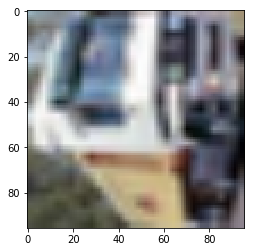

(128, 64, 27649)
(2048, 27649)
proprocess time is 2.766016


In [8]:
start = clock()
Train_data, Test_data = Net_Train.loadTrainTestData(Data, Batch_size, resize=Size)
print(Train_data.shape)
print(Test_data.shape)
end = clock()
time = end - start;
print("proprocess time is %f" % (time))

In [13]:
print(len(Train_data))
Net_Train.train(Train_data, Test_data, ResNet, 50, loss, Trainer, size=Size, ctx=ctx)

128
Echoe is 1, Train Loss is 2.488012, Train Acc is 0.153931, Test Acc is 0.228027, Use-time is 5.639437 S
Echoe is 2, Train Loss is 1.932411, Train Acc is 0.269775, Test Acc is 0.295898, Use-time is 5.464847 S
Echoe is 3, Train Loss is 1.765755, Train Acc is 0.342896, Test Acc is 0.359375, Use-time is 5.421780 S
Echoe is 4, Train Loss is 1.643057, Train Acc is 0.386230, Test Acc is 0.390625, Use-time is 5.601101 S
Echoe is 5, Train Loss is 1.543481, Train Acc is 0.422607, Test Acc is 0.408203, Use-time is 5.473481 S
Echoe is 6, Train Loss is 1.453157, Train Acc is 0.459106, Test Acc is 0.433594, Use-time is 5.789523 S
Echoe is 7, Train Loss is 1.362204, Train Acc is 0.492188, Test Acc is 0.445801, Use-time is 5.904637 S


KeyboardInterrupt: 

# 在调试过程中存在的几个问题！
1. 由于数据量过大，直接放入内存或者GPU会导致Memroy不足的提示
2. 利用自己的train函数，训练输出的结果近似等于没有训练

方法：
1. 数据部分训练的原则，每次都取部分数据进行分析，分析完后及时释放
2. 利用MNIST的数据，对自己编写的train函数进行进一步的测试！